In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots
import pickle
import scipy

from utils import utils
import utils.efinet as efinet
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import auc, roc_curve, RocCurveDisplay
# import cuml

In [87]:
results_roc = []
results_roc_aug = []

In [98]:
# Plot settings
fpath = "C:/Users/Marek/OneDrive/School/DP/masters-thesis/assets/figures/wesad"
# plt.rcParams["font.family"] = ["Latin Modern Roman"]
plt.rcParams["figure.figsize"] = (5, 5)
plt.style.use("science")
# plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 14

mark = "1s"

In [99]:
# Load labels
with open(f"../data/Merged/WESAD_merged_{mark}.pkl", "rb") as f:
    labels = pickle.load(f)
labels = labels["model_label"]

# Load and concat data
with open(f"../data/GADF_Data/GADF_WESAD_merged_{mark}.pkl", "rb") as f:
    gadf_wesad = pickle.load(f)

gcn_wesad = scipy.io.loadmat(f"../data/GCN_Data/GCN_WESAD_Standard_{mark}.mat")
gcn_wesad = np.transpose(gcn_wesad["cause5s"], (0, 2, 3, 1))

L = len(gcn_wesad)

result_wesad = []
for i in range(L):
    result_wesad.append(gcn_wesad[i] + gadf_wesad[i])

data = np.array(result_wesad)

# Split data into train and test
X, y = data, labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

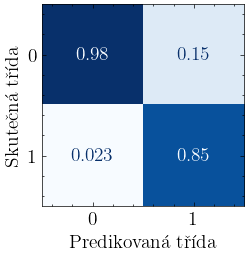

In [100]:
_, eval_model = efinet.build_graph([32, 32, 3], 2, verbose=False)
eval_model.load_weights(f"../results/models/WESAD_{mark}.h5")

# Predict the values from the validation dataset
Y_pred = eval_model.predict(X_test)

Y_true = np.argmax(y_test, axis=1)
fpr, tpr, thresholds = roc_curve(Y_true, Y_pred[0][:, 1])
roc_auc = auc(fpr, tpr)
results_roc.append([fpr, tpr, roc_auc])
# utils.print_stats(y_test, Y_pred)
utils.plot_confusion_matrix(y_test, Y_pred, normalize="pred")
plt.savefig(f"{fpath}/wesad_{mark}.pdf", format="pdf", bbox_inches="tight")

In [101]:
with open(f"../data/augmented_cuml/WESAD_{mark}_AUG.pkl", "rb") as f:
    data = pickle.load(f)
    X_res, y_res = data["X"], data["y"]

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

y_train_res = to_categorical(y_train_res, num_classes=2)
y_test_res = to_categorical(y_test_res, num_classes=2)

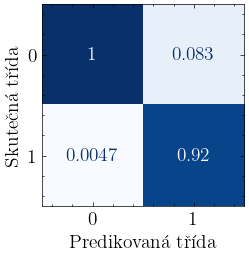

In [102]:
_, eval_model_aug = efinet.build_graph([32, 32, 3], 2)
eval_model_aug.load_weights(f"../results/models/WESAD_{mark}_AUG.h5")

# Predict the values from the validation dataset
Y_pred_aug = eval_model_aug.predict(X_test_res)

Y_true_aug = np.argmax(y_test_res, axis=1)
fpr_aug, tpr_aug, thresholds_aug = roc_curve(Y_true_aug, Y_pred_aug[0][:, 1])
roc_auc_aug = auc(fpr_aug, tpr_aug)
results_roc_aug.append([fpr_aug, tpr_aug, roc_auc_aug])
# utils.print_stats(y_test_res, Y_pred_aug)
utils.plot_confusion_matrix(y_test_res, Y_pred_aug)
plt.savefig(f"{fpath}/wesad_{mark}_aug.pdf", format="pdf", bbox_inches="tight")

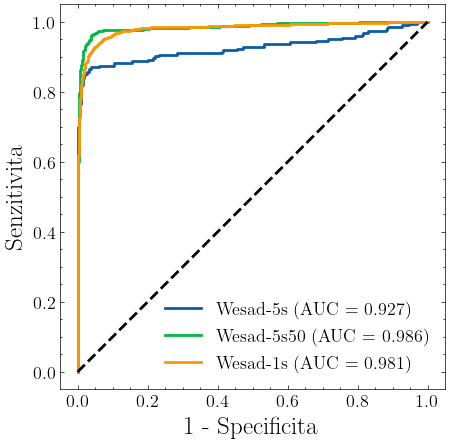

In [136]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["font.size"] = 13

plt.figure()
plt.plot(results_roc[0][0], results_roc[0][1], label=f"Wesad-5s (AUC = {np.round(results_roc[0][2], 3)})", linewidth=2)
plt.plot(results_roc[1][0], results_roc[1][1], label=f"Wesad-5s50 (AUC = {np.round(results_roc[1][2], 3)})", linewidth=2)
plt.plot(results_roc[2][0], results_roc[2][1], label=f"Wesad-1s (AUC = {np.round(results_roc[2][2], 3)})", linewidth=2)
plt.legend()
plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.axis("square")
plt.ylabel("Senzitivita", fontsize=18)
plt.xlabel("1 - Specificita", fontsize=18)
plt.savefig(f"{fpath}/wesad_roc.pdf", format="pdf", bbox_inches="tight")

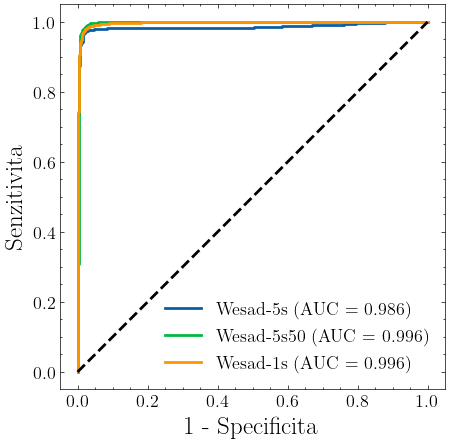

In [137]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["font.size"] = 13

plt.figure()
plt.plot(results_roc_aug[0][0], results_roc_aug[0][1], label=f"Wesad-5s (AUC = {np.round(results_roc_aug[0][2], 3)})", linewidth=2)
plt.plot(results_roc_aug[1][0], results_roc_aug[1][1], label=f"Wesad-5s50 (AUC = {np.round(results_roc_aug[1][2], 3)})", linewidth=2)
plt.plot(results_roc_aug[2][0], results_roc_aug[2][1], label=f"Wesad-1s (AUC = {np.round(results_roc_aug[2][2], 3)})", linewidth=2)
plt.legend(frameon=False)
plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.axis("square")
plt.ylabel("Senzitivita", fontsize=18)
plt.xlabel("1 - Specificita", fontsize=18)
plt.savefig(f"{fpath}/wesad_roc_aug.pdf", format="pdf", bbox_inches="tight")